This is the original kernel I wrote, actually it is almost exclusively me dealing with data imputation. I will probably have to extract the data imputation into a proper file, when I need it for models that can't deal with nans.

NOTE: THIS IS CURRENETLY BROKEN.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import call
import lightgbm as lgb

from sklearn import ensemble, metrics, decomposition, preprocessing, utils, model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics, cluster

from pandas.tools.plotting import scatter_matrix

os.chdir('../')
call(['make', 'data/interm/binary_data.h5'])
os.chdir('src')
%load_ext autoreload
%autoreload 1

%aimport models.lightgbm_model
%aimport features.simple_features
import models.lightgbm_model as lgb_model


/home/adrian/.conda/envs/kmapper/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


TODOS:
Amazing kernel: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

In [2]:
app_train = features.simple_features.read_data('application_train', base_path='../')
app_test = features.simple_features.read_data('application_test', base_path='../')

app = app_train.append(app_test, ignore_index=True, sort=True)
app.drop('SK_ID_CURR', axis=1, inplace=True)

Read data - done in 0s
Read data - done in 0s


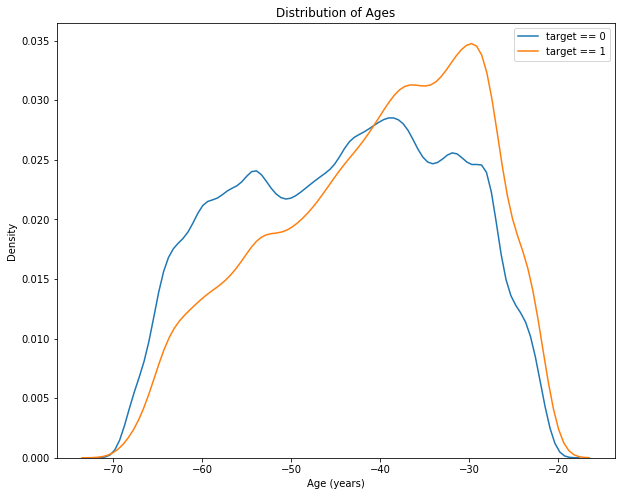

In [3]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

## Small peak at the data

In [4]:
display(len(app_train))
display(app_train.sample(5))

307511

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
252170      391780       0         Cash loans           F            N   
18065       121069       0    Revolving loans           F            N   
232231      368987       0         Cash loans           M            Y   
223951      359393       1         Cash loans           M            Y   
254676      394700       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
252170               Y             0          112500.0    733500.0   
18065                Y             0          225000.0    585000.0   
232231               Y             0          135000.0    490495.5   
223951               Y             1          157500.0    675000.0   
254676               Y             0           54000.0    168102.0   

        AMT_ANNUITY             ...              FLAG_DOCUMENT_18  \
252170      22369.5             ...                             0   
18065       29250.0             ...                             0   
232231      27517.5             ...                             0   
223951      24246.0             ...                             0   
254676      16375.5             ...                             0   

       FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
252170                0                0                0   
18065                 0                0                0   
232231                0                0                0   
223951                0                0                0   
254676                0                0                0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
252170                        NaN                       NaN   
18065                         0.0                       0.0   
232231                        NaN                       NaN   
223951                        0.0                       0.0   
254676                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
252170                         NaN                        NaN   
18065                          0.0                        0.0   
232231                         NaN                        NaN   
223951                         0.0                        0.0   
254676                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
252170                        NaN                         NaN  
18065                         0.0                         4.0  
232231                        NaN                         NaN  
223951                        0.0                         3.0  
254676                        0.0                         1.0  

[5 rows x 122 columns]

And also let's correct a weird mistake that displayed missing values for `DAYS_EMPLOYED` as 365243.

In [5]:
app.loc[app.DAYS_EMPLOYED == 365243, 'DAYS_EMPLOYED'] = np.nan

Let's also define the a few variable groups there are.

In [6]:
print(app.dtypes.value_counts())

housing_feature_mask = (app.isnull().sum() > 100000)  # those just happen to be the housing features
housing_feature_mask.EXT_SOURCE_1 = False
housing_feature_mask.OWN_CAR_AGE = False
housing_features = housing_feature_mask[housing_feature_mask].keys()

float32    65
uint8      35
object     16
int64       3
float64     2
dtype: int64


# Data imputation

Since LightGBM can deal with missing values on its own, the next section isn't required for that model.

## Imptute float features that are really integers

TODO: The correct imputation solution for `AMT_REQ_CREDIT_BUREAU_[time]`, `DAYS_EMPLOYED` is probably binning.

In [7]:
int_feature_mask = (app[app.keys()[app.dtypes == 'float64']] % 1).sum() == 0
int_features = int_feature_mask[int_feature_mask].keys()
display(app.loc[:, int_features].isnull().sum())

DAYS_EMPLOYED    64648
TARGET           48744
dtype: int64

In [8]:
app.loc[app.DEF_30_CNT_SOCIAL_CIRCLE.isnull(), 'DEF_30_CNT_SOCIAL_CIRCLE'] = -1
display(app[['DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']].groupby('DEF_30_CNT_SOCIAL_CIRCLE').mean())
app.loc[app.DEF_30_CNT_SOCIAL_CIRCLE == -1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = np.nan

TARGET
DEF_30_CNT_SOCIAL_CIRCLE          
-1.0                      0.035260
 0.0                      0.077759
 1.0                      0.101454
 2.0                      0.116476
 3.0                      0.128356
 4.0                      0.138340
 5.0                      0.142857
 6.0                      0.090909
 7.0                      0.000000
 8.0                      0.000000
 34.0                     0.000000

It is interesting to see that for most of the features above, the fact that a value is missing is actually relevant, so imputing it might actually be harmfull.

In [9]:
print(((app.FLAG_OWN_CAR == 'Y') & (app.OWN_CAR_AGE.isnull())).sum())
int_features = int_features.drop('TARGET')

print(app.AMT_REQ_CREDIT_BUREAU_QRT.value_counts())

app_int = app.loc[:, int_features]
app.loc[:, int_features] = app_int.fillna(app_int[:10000].mode().T.to_dict()[0])
app.loc[:, int_features] = app.loc[:, int_features].astype(np.int32)

6
0.0      238976
1.0       49435
2.0       17410
3.0        2212
4.0         533
5.0          75
6.0          29
7.0           8
8.0           7
19.0          1
261.0         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64


In [10]:
app.sample(5)

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
250448      21550.5    373140.0         337500.0           92250.0   
105515      16272.0    611964.0         400500.0           81000.0   
318458      56704.5    540000.0         540000.0          247500.0   
190644      49878.0    473760.0         450000.0          675000.0   
161968       9508.5    134775.0         112500.0          178650.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
250448                        NaN                         NaN   
105515                        0.0                         0.0   
318458                        0.0                         0.0   
190644                        0.0                         0.0   
161968                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
250448                        NaN                        NaN   
105515                        0.0                        2.0   
318458                        0.0                        0.0   
190644                        0.0                        0.0   
161968                        0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
250448                         NaN                         NaN   
105515                         0.0                         2.0   
318458                         0.0                         0.0   
190644                         0.0                         1.0   
161968                         0.0                         4.0   

              ...         TARGET  TOTALAREA_MODE  WALLSMATERIAL_MODE  \
250448        ...            0.0             NaN                 NaN   
105515        ...            0.0             NaN                 NaN   
318458        ...            NaN             NaN                 NaN   
190644        ...            0.0             NaN                 NaN   
161968        ...            0.0          0.2898               Panel   

        WEEKDAY_APPR_PROCESS_START  YEARS_BEGINEXPLUATATION_AVG  \
250448                   WEDNESDAY                          NaN   
105515                     TUESDAY                          NaN   
318458                     TUESDAY                          NaN   
190644                    THURSDAY                          NaN   
161968                   WEDNESDAY                       0.9906   

        YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE  \
250448                           NaN                           NaN   
105515                           NaN                           NaN   
318458                           NaN                           NaN   
190644                           NaN                           NaN   
161968                        0.9906                        0.9906   

        YEARS_BUILD_AVG YEARS_BUILD_MEDI  YEARS_BUILD_MODE  
250448              NaN              NaN               NaN  
105515              NaN              NaN               NaN  
318458              NaN              NaN               NaN  
190644              NaN              NaN               NaN  
161968           0.8708           0.8725            0.8759  

[5 rows x 121 columns]

## Impute proper float features

All data with over 1000 missing values is eigther housing data or ratings from external sources. Both of these are probably **very** valuable, its a shame that half the housing data is missing and a decent portion of the ratings, too. I will definetly try a classifier only based on `EXT_SOURCE_[n]`, it could be a solid baseline. Regarding the housing data, I will need a model that tolerates missing data or build two models.

TODO: Add `HAS_HOUSING_DATA` feature. Regarding the cluster that actually has housing, we could engineer a `HOUSE_VALUE` feature, because I don't see how the model would use eg `ELEVATORS_MEDI` directly.

In [11]:
(app.APARTMENTS_AVG.isnull() & app.BASEMENTAREA_AVG.isnull() & app.COMMONAREA_AVG.isnull() & app.ELEVATORS_AVG.isnull() & app.ENTRANCES_AVG.isnull()).sum()

175439

In [12]:
proper_floats = app.keys()[app.dtypes == 'float64']
print(app[proper_floats].isnull().sum())

proper_floats = app.keys()[app.dtypes == 'float64'].drop('TARGET')

imputable_feature_mask = (app[proper_floats].isnull().sum() < 1000)
imputable_features = imputable_feature_mask[imputable_feature_mask].keys()
app_imp = app.loc[:, imputable_features]
app.loc[:, imputable_features] = app_imp.fillna(app_imp[:10000].mean().T.to_dict())

TARGET    48744
dtype: int64


## Integer data

 2    265260
 3     50652
 1     40342
-1         1
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


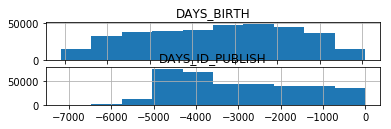

In [13]:
int_features = app[app.keys()[app.dtypes == 'int64']].keys()
i = 1
for k in int_features:
    c = app[k].value_counts()

    if len(c) < 5:
        print(app[k].value_counts().head())
    else:
        plt.subplot(5, 1, i)
        i = i + 1
        app[k].hist()
        plt.title(k)
    
    if (len(c) == 2):
        if c[1] < 50:
            print('dropping ', k)
            app = app.drop(k, axis=1)


TODO: Maybe I should convert the 3-feature data to a one-hot encoding.

# Encoding class data

We will have to make sure that categories are factorized correctly, in case the variable has a clear ordering of , and that too high class counts get correctly handled.

In [14]:
types = app.dtypes
string_features = types[types == 'object'].keys()

null_counts = app[string_features].isnull().sum()
unique = app[string_features].nunique()
na_info = pd.DataFrame({'null_count': null_counts, 'unique': unique})
na_info.sort_values(by=['null_count'])

null_count  unique
CODE_GENDER                          0       3
FLAG_OWN_CAR                         0       2
FLAG_OWN_REALTY                      0       2
NAME_CONTRACT_TYPE                   0       2
NAME_EDUCATION_TYPE                  0       5
NAME_FAMILY_STATUS                   0       6
NAME_HOUSING_TYPE                    0       6
NAME_INCOME_TYPE                     0       8
ORGANIZATION_TYPE                    0      58
WEEKDAY_APPR_PROCESS_START           0       7
NAME_TYPE_SUITE                   2203       7
OCCUPATION_TYPE                 111996      18
EMERGENCYSTATE_MODE             167964       2
HOUSETYPE_MODE                  177916       3
WALLSMATERIAL_MODE              180234       7
FONDKAPREMONT_MODE              243092       4

In [15]:
print(app.NAME_EDUCATION_TYPE.value_counts())
print(app.NAME_EDUCATION_TYPE.head())
print(app.NAME_EDUCATION_TYPE.factorize()[0])

#edu = pd.get_dummies(app.NAME_EDUCATION_TYPE, prefix='Education')
#pca = decomposition.PCA()

#pca.fit_transform(edu)
#data_df = pd.concat([data_df, pclass], axis=1

Secondary / secondary special    252379
Higher education                  87379
Incomplete higher                 12001
Lower secondary                    4291
Academic degree                     205
Name: NAME_EDUCATION_TYPE, dtype: int64
0    Secondary / secondary special
1                 Higher education
2    Secondary / secondary special
3    Secondary / secondary special
4    Secondary / secondary special
Name: NAME_EDUCATION_TYPE, dtype: object
[0 1 0 ... 0 1 0]


In [16]:
def as_dict(l):
    return dict(map(lambda e: (e[1], e[0]), enumerate(l)))


def dict_as_mapping(d):
    return (lambda idx: -1 if idx is np.nan else d[idx])


def factorize_by_probs(frame, key):
    d = as_dict(app[[key, 'TARGET']].groupby(key).mean().sort_values('TARGET').T.keys())
    print('Using {} as a ordering for {}'.format(d, key))
    mapping = dict_as_mapping(d)
    
    return frame[key].apply(mapping)

The missing housing data definetly contains some good value, as one can see below. We can deal with it later, for now it will be dropped.

In [17]:
from scipy.stats import chi2_contingency
display(app[['EMERGENCYSTATE_MODE', 'TARGET']].groupby('EMERGENCYSTATE_MODE').mean())
props = pd.crosstab(app_train.EMERGENCYSTATE_MODE, app.TARGET)
c = chi2_contingency(props, lambda_="log-likelihood")
print(props, "\n p-value= ", c[1])

TARGET
EMERGENCYSTATE_MODE          
No                   0.069649
Yes                  0.095790

TARGET                  0.0    1.0
EMERGENCYSTATE_MODE               
No                   148324  11104
Yes                    2105    223 
 p-value=  3.63029154462634e-06


TODO: deal with `ORGANIZATION_TYPE` `OCCUPATION_TYPE` high class counts.

In [18]:
types = app.dtypes
string_features = types[types == 'object'].keys()
for key in string_features:
#     if unique(k) <= 3:
    #app[key] = app[key].factorize()[0]
    app[key] = factorize_by_probs(app, key)
#     elif (unique(k) > 3) & (unique(k) < 4):
#         app.NAME_EDUCATION_TYPE.value_counts()
#         edu = pd.get_dummies(app.NAME_EDUCATION_TYPE, prefix='Education')
#         pca = decomposition.PCA()

#         pca.fit_transform(edu)
#         #data_df = pd.concat([data_df, pclass], axis=1
        

Using {'XNA': 0, 'F': 1, 'M': 2} as a ordering for CODE_GENDER
Using {'No': 0, 'Yes': 1} as a ordering for EMERGENCYSTATE_MODE


KeyError: nan

# Feature engineering

In [77]:
app.head()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0      24700.5    406597.5         351000.0          202500.0   
1      35698.5   1293502.5        1129500.0          270000.0   
2       6750.0    135000.0         135000.0           67500.0   
3      29686.5    312682.5         297000.0          135000.0   
4      21865.5    513000.0         513000.0          121500.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR        ...         \
0                         0.0                         1.0        ...          
1                         0.0                         0.0        ...          
2                         0.0                         0.0        ...          
3                         NaN                         NaN        ...          
4                         0.0                         0.0        ...          

   TARGET  TOTALAREA_MODE  WALLSMATERIAL_MODE  WEEKDAY_APPR_PROCESS_START  \
0     1.0          0.0149                   3                           5   
1     0.0          0.0714                   2                           0   
2     0.0             NaN                  -1                           0   
3     0.0             NaN                  -1                           5   
4     0.0             NaN                  -1                           3   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MEDI  \
0                       0.9722                        0.9722   
1                       0.9851                        0.9851   
2                          NaN                           NaN   
3                          NaN                           NaN   
4                          NaN                           NaN   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_AVG  YEARS_BUILD_MEDI  \
0                        0.9722           0.6192            0.6243   
1                        0.9851           0.7960            0.7987   
2                           NaN              NaN               NaN   
3                           NaN              NaN               NaN   
4                           NaN              NaN               NaN   

   YEARS_BUILD_MODE  
0            0.6341  
1            0.8040  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 121 columns]

In [78]:
app['CREDIT_TERM'] = app.AMT_CREDIT / app.AMT_ANNUITY  # length of payment in months
app['OVER_EXPECT_CREDIT'] = app.AMT_CREDIT > app.AMT_GOODS_PRICE 
#app['BIRTH_EMPLOYED_INTERVAL'] = app.DAYS_EMPLOYED - app.DAYS_BIRTH
app['INCOME_PER_FAMILY_MEMBER'] = app.AMT_INCOME_TOTAL / app.CNT_FAM_MEMBERS
app['SEASON_REMAINING'] = app.AMT_INCOME_TOTAL / 4 - app.AMT_ANNUITY
app['INCOME_GOODS_DIFF'] = app.AMT_INCOME_TOTAL - app.AMT_GOODS_PRICE
app['CHILDREN_RATIO'] = app['CNT_CHILDREN'] / app['CNT_FAM_MEMBERS']

app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['DAYS_EMPLOYED_PERCENT'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
app['ANNUITY_INCOME_PERCENT'] = app['AMT_ANNUITY'] / app['AMT_INCOME_TOTAL']

In [79]:
#application_train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = application_train.iloc[:, 116:122].sum(axis=1)
#application_train['FLAG_DOCUMENT_TOTAL'] = application_train.iloc[:, 96:116].sum(axis=1)

In [80]:
#app = app.drop(['FONDKAPREMONT_MODE','WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE'], axis=1)
app.drop(housing_features, axis=1, inplace=True)

## Fit a model

In [104]:
X = app[-app.TARGET.isnull()].drop('TARGET', axis=1)
y = app[-app.TARGET.isnull()].TARGET
X_pred = app[app.TARGET.isnull()].drop('TARGET', axis=1)

dataset = lgb.Dataset(data=X, label=y)
desc = 'lightgbm with the data imputation notebook'
m.cv_log(dataset, 'baseline', description=desc)